![imagen](data/foto1.png)

![imagen](data/foto2.png)

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor.

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [2]:
df = pd.read_csv("./air_pollution_new_city.csv", sep = "|")

In [3]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


*No hay nulos, y parece que el dataset empieza el 2 de enero de 2019, nos falta el primer día. No vamos a considerar que tenga mucho impacto teniendo 43800 horas de datos*

*Solo hay una variable categórica que es la dirección combinada del viento y el resto son numéricas (en definitiva son series :-), es un dataset multivariado o multivariante*

*El target parece claramente (por descarte) la columna pm2.5 así que la marcamos como tal*

In [5]:
target = "pm2.5"

### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

*Eliminamos No que es básicamente un índice*

In [6]:
df.drop("No", axis = 1, inplace = True)

*Renombramos columnas*

In [7]:
df.rename(columns={"DEWP":"rocio","TEMP":"temperatura","PRES":"presion","cbwd":"dir_viento","Iws":"vel_viento","Is":"horas_nieve","Ir":"horas_lluvia"}, inplace = True)

*Preparando el índice*

In [8]:
date_columns = ["year","month","day","hour"]
df["fecha"] = pd.to_datetime(df[date_columns])
df_indexed = df.set_index("fecha")
df_indexed.sort_index(inplace = True)
df_indexed.drop(date_columns, axis =1, inplace = True)

### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

*Primero nos creamos el dataset de train*

In [9]:
df_train = df_indexed[:"2022"]

*Vamos con el análisis del target*

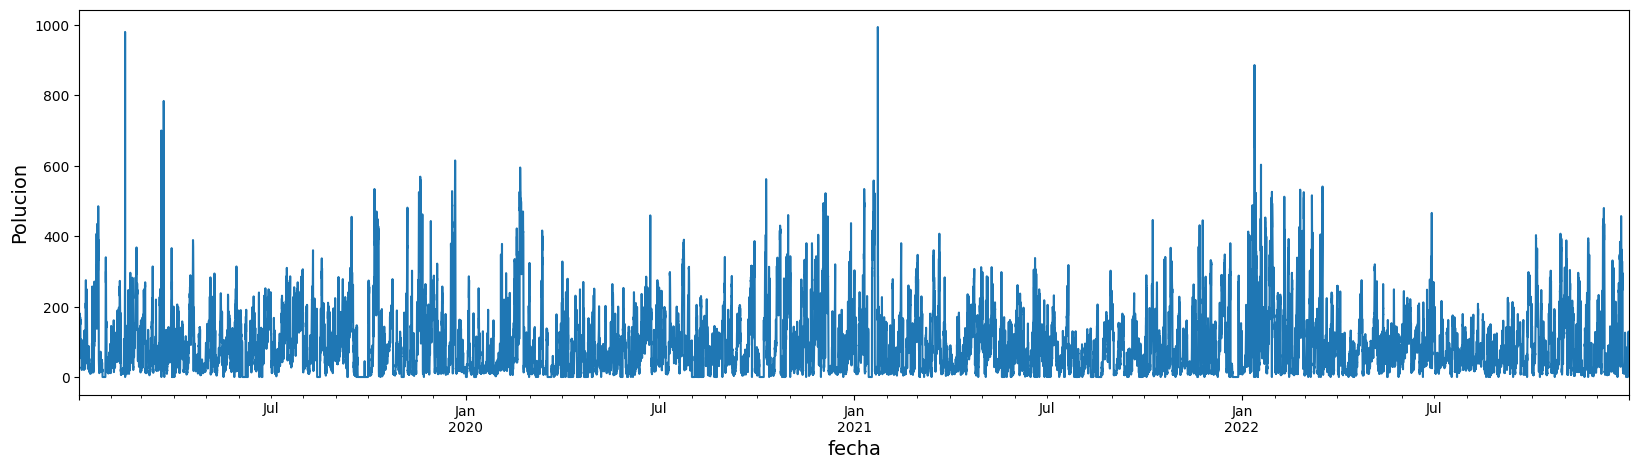

In [10]:
df_train[target].plot(figsize = (20,5))
plt.ylabel("Polucion");


*Así tal cual no se ve mucho en terminos de trend o sesonality. Hagamos una descomposición*

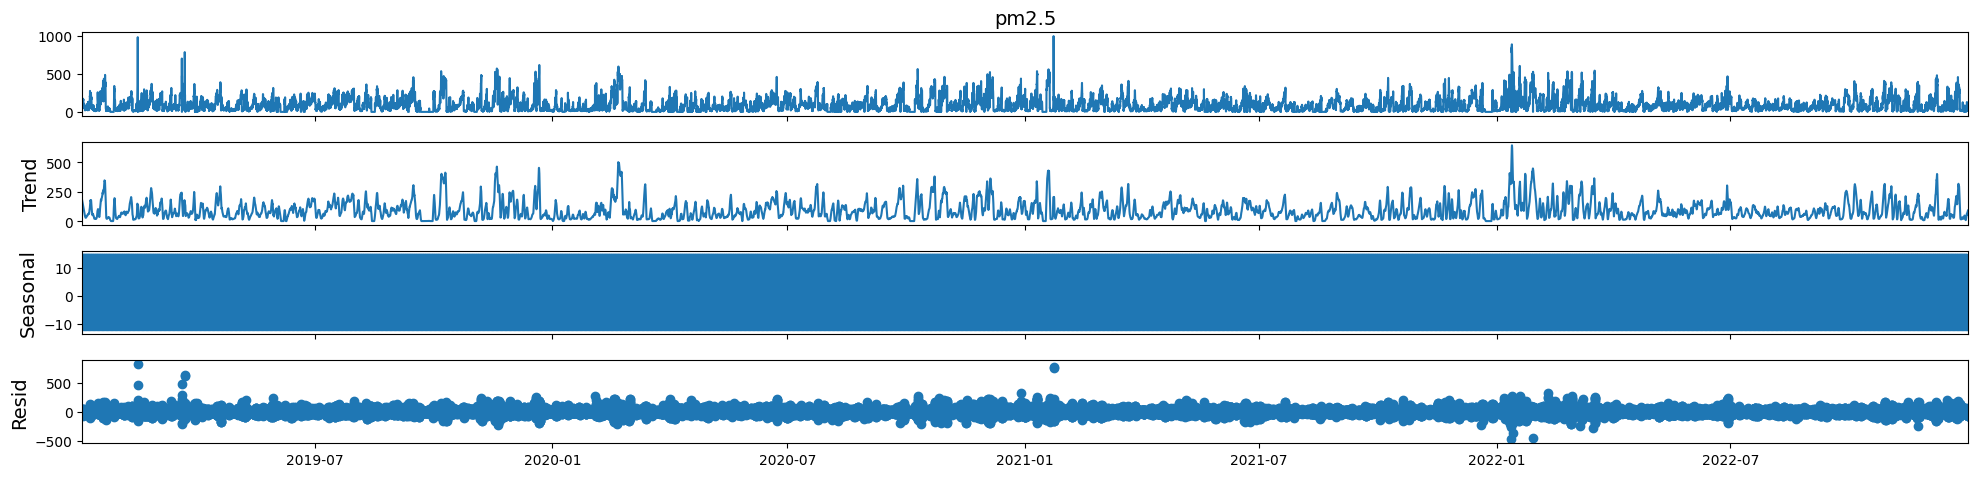

In [11]:
result_add = seasonal_decompose(df_train[target], model = 'additive', extrapolate_trend = 'freq')
# Plot
plt.rcParams.update({'figure.figsize': (20,5)})
result_add.plot();

In [12]:
df_train[target].describe()

,pm2.5
count,35040.000000
mean,93.359389
std,91.908697
min,0.000000
25%,24.000000
50%,67.000000
75%,133.000000
max,994.000000


*Aunque puede parecer que existe una componente estacional, los niveles de la misma son mínmos (+-10 sobre valores medios de 90) y la tendencia sigue básicameente a la serie. No podemos estar seguros de que exista una estacionalidad o tendencia a NIVEL HORARIO*

In [13]:
result = adfuller(df_train[target].values)
result[1]

0.0

*Si hacemos el test de Dickey-Fuller aumentado nos dice que podemos tratar la serie como estacionaria*

*Podríamos probar un ARIMA directamente sin diferenciar, pero lo haremos con redes*

### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

In [14]:
series_col = [target] + [col for col in df_train.columns if df_train[col].dtype != "object" and col != target]
series_col

['pm2.5',
 'rocio',
 'temperatura',
 'presion',
 'vel_viento',
 'horas_nieve',
 'horas_lluvia']

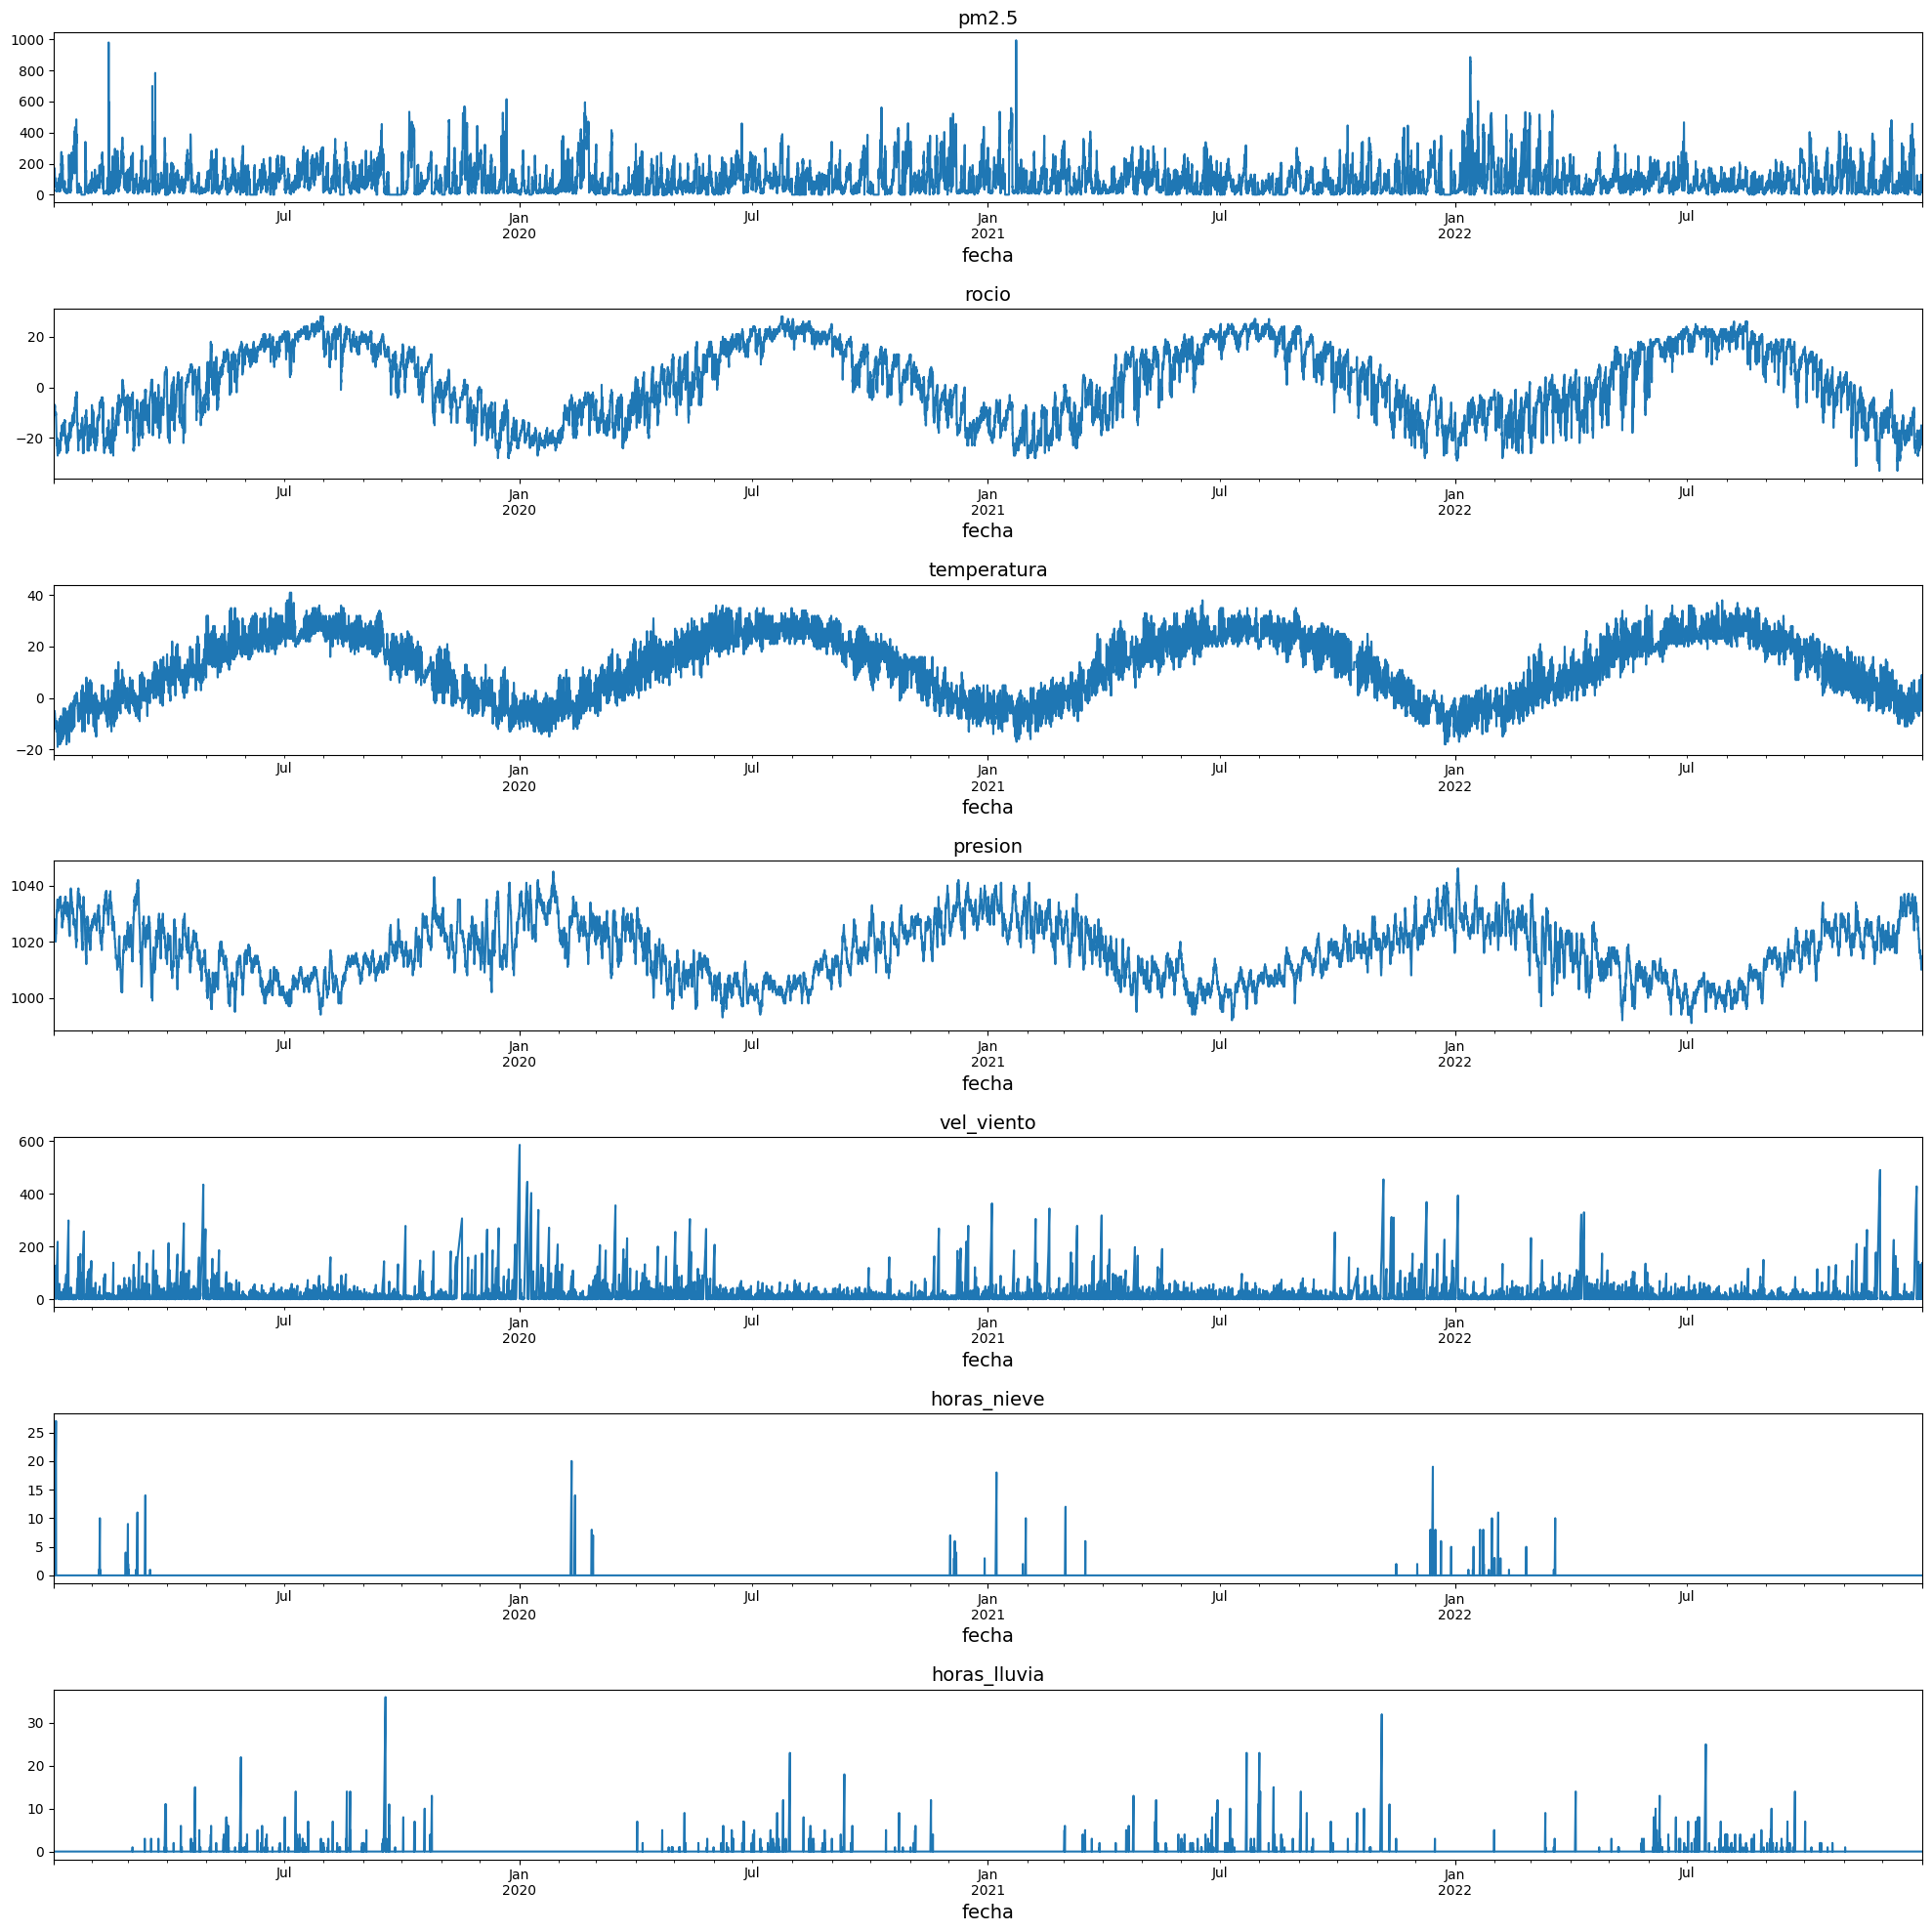

In [15]:
fig,axs = plt.subplots(len(series_col),1, figsize = (20,20))
for indice,col in enumerate(series_col):
    df_train[col].plot(ax = axs[indice])
    axs[indice].set_title(col)
plt.tight_layout();


*Así de primeras, parece que la nieve y el viento aumentan la contaminación y es la lluvia la que la disminuye o por lo menos que existen correlaciones con estos procesos, y con las medidas de presión,temperatura y punto de rocío de estos fenómenos*

### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final:

In [16]:
df_indexed["dir_viento"].value_counts()

,count
dir_viento,
SE,15290
NW,14130
cv,9384
NE,4996


In [17]:
from sklearn.preprocessing import OneHotEncoder

col_onehot = [f"dir_viento_{valor}" for valor in df_indexed["dir_viento"].unique()]
onehot = OneHotEncoder()
df_indexed[col_onehot] = onehot.fit_transform(df_indexed[["dir_viento"]]).toarray()
df_indexed.drop("dir_viento", axis = 1, inplace = True)

*Lo hacemos sobre df_indexed porque las direcciones del viento son las que son, no van a aparecer unas nuevas en principio (es algo "estipulado") y podemos saberlas con antelación (ojo, no los valores de cada hora sino las "etiquetas" de la variable)*

In [18]:
df_indexed = df_indexed.astype(np.float32)

### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [19]:
df_train_mulvar = df_indexed[:"2023-09"].copy()
df_valid_mulvar = df_indexed["2023-09-29":"2023-11-01"].copy()
df_test_mulvar = df_indexed["2023-10-30":"2023-12-01"].copy()

In [20]:
from sklearn.preprocessing import StandardScaler

series_col.remove(target)
scaler = StandardScaler()
df_train_mulvar[series_col] = scaler.fit_transform(df_train_mulvar[series_col])
df_valid_mulvar[series_col] = scaler.transform(df_valid_mulvar[series_col])
df_test_mulvar[series_col] = scaler.transform(df_test_mulvar[series_col])

scaler_target = StandardScaler()
df_train_mulvar[[target]] = scaler_target.fit_transform(df_train_mulvar[[target]])
df_valid_mulvar[[target]] = scaler_target.transform(df_valid_mulvar[[target]])
df_test_mulvar[[target]] = scaler_target.transform(df_test_mulvar[[target]])


### Ejercicio 7

Prepara los batches siguiendo los pasos que has visto en el workload para multivariante y periodos múltiples

In [21]:
df_train_mulvar.to_numpy().dtype

dtype('float32')

In [22]:
df_train_mulvar.dtypes

,0
pm2.5,float32
rocio,float32
temperatura,float32
presion,float32
vel_viento,float32
horas_nieve,float32
horas_lluvia,float32
dir_viento_SE,float32
dir_viento_cv,float32
dir_viento_NW,float32


In [23]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

seq_length = 48# Secuencias de 48 horas
prediction_interval = 6# Predecimos las 6 horas siguientes

def split_inputs_and_targets(mulvar_series, ahead= prediction_interval, target_col= list(df_indexed.columns).index(target)):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_train_mulvar.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval, # Alargamos las secuencias
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets) # Tenemos que hacer un pequeño truco para tener los target

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_valid_mulvar.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval,
    batch_size=32
).map(split_inputs_and_targets)

ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_test_mulvar.to_numpy(),
    targets=None,
    sequence_length=seq_length + prediction_interval,
    batch_size=32
).map(split_inputs_and_targets)

### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

*Creamo el modelo como hemos visto en el workout (pero ojo tendrás que cambiar el input_shape para que tenga las features del multivariante y el número de unidades de la densa en función del  número de periodos predichos*

In [24]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length,len(df_train_mulvar.columns),)), # OJO ESTO ES DIFERNTE SIGUIENDO EL CONSEJO DEL WARNING QUE SALE SI LO HACES COMO EN EL WORKOUT
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(prediction_interval)
])

*Recuperamos la función que teníamos en el workout para fittear y evaluar, modificando para que haga la inversión del escalado*

In [25]:
scaler_target.inverse_transform([[0.38,0.12]])

array([[127.99515246, 104.30279392]])

In [26]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500, patience = None, scaler = scaler_target):
    patience = int(epochs//10) if patience == None else patience # Si no nos dan "paciencia" el 10% de las épocas
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience= patience, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=["mae","root_mean_squared_error"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae, valid_rmse = model.evaluate(valid_set)
    return scaler_target.inverse_transform([[valid_mae, valid_rmse]])

In [27]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, epochs = 100, learning_rate=0.01)

Epoch 1/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.3390 - mae: 0.3644 - root_mean_squared_error: 0.5757 - val_loss: 0.2600 - val_mae: 0.3319 - val_root_mean_squared_error: 0.5099
Epoch 2/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.2498 - mae: 0.3054 - root_mean_squared_error: 0.4997 - val_loss: 0.2529 - val_mae: 0.3256 - val_root_mean_squared_error: 0.5029
Epoch 3/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.2434 - mae: 0.3005 - root_mean_squared_error: 0.4933 - val_loss: 0.2502 - val_mae: 0.3165 - val_root_mean_squared_error: 0.5002
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.2411 - mae: 0.3002 - root_mean_squared_error: 0.4909 - val_loss: 0.2340 - val_mae: 0.3076 - val_root_mean_squared_error: 0.4838
Epoch 5/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.2372 - mae: 0.2962 - root_mean_squared_error: 0.4870 - val_loss: 0.2379 - val_mae: 0.3064 - val_root_mean_squared_error: 0.4878
Epoch 6/100
1299/1299 ━━━

array([[120.32199534, 135.91889909]])

*No parece que vamos a obtener un gran modelo. Ese MAE y es RMSE comparados con los valores medios...*

In [28]:
scaler_target.inverse_transform([[df_valid_mulvar[target].describe()["mean"]]])

array([[131.82843212]])

*Cometemos errores de contaminación del orden de la media...*

In [29]:
_, mae, rmse = ahead_model.evaluate(ahead_test_ds)
scaler_target.inverse_transform([[mae,rmse]])

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2726 - mae: 0.2776 - root_mean_squared_error: 0.5102


array([[124.66877472, 150.57297804]])

*Hmmm, no todo nos iba a salir tan bien a la primera... Bueno parece que no tenemos un problema fácil. Vete acostumbrando. Lo importante ahora es que juegues con keras y las RNN. Por eso lo vamos a intentar con LSTM y GRU aunque no saldrá mucho mejor*

### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [30]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length,len(df_train_mulvar.columns),)), # OJO ESTO ES DIFERNTE SIGUIENDO EL CONSEJO DEL WARNING QUE SALE SI LO HACES COMO EN EL WORKOUT
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(prediction_interval)
])

In [31]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, epochs = 100, learning_rate=0.01)

Epoch 1/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - loss: 0.3608 - mae: 0.3821 - root_mean_squared_error: 0.5955 - val_loss: 0.2607 - val_mae: 0.3378 - val_root_mean_squared_error: 0.5106
Epoch 2/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: 0.2431 - mae: 0.3001 - root_mean_squared_error: 0.4929 - val_loss: 0.2340 - val_mae: 0.3059 - val_root_mean_squared_error: 0.4837
Epoch 3/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: 0.2338 - mae: 0.2923 - root_mean_squared_error: 0.4834 - val_loss: 0.2284 - val_mae: 0.3029 - val_root_mean_squared_error: 0.4779
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - loss: 0.2289 - mae: 0.2886 - root_mean_squared_error: 0.4783 - val_loss: 0.2225 - val_mae: 0.2971 - val_root_mean_squared_error: 0.4717
Epoch 5/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - loss: 0.2259 - mae: 0.2863 - root_mean_squared_error: 0.4752 - val_loss: 0.2205 - val_mae: 0.2966 - val_root_mean_squared_error: 0.4695
Epoch 6/100
1299/1299 ━━━

array([[117.9872036 , 133.09686365]])

In [32]:
_, mae, rmse = ahead_model.evaluate(ahead_test_ds)
scaler_target.inverse_transform([[mae,rmse]])

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2313 - mae: 0.2563 - root_mean_squared_error: 0.4651


array([[123.52198845, 148.80798789]])

### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [33]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length,len(df_train_mulvar.columns),)), # OJO ESTO ES DIFERNTE SIGUIENDO EL CONSEJO DEL WARNING QUE SALE SI LO HACES COMO EN EL WORKOUT
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(prediction_interval)
])

In [34]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, epochs = 100, learning_rate=0.01)

Epoch 1/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.3374 - mae: 0.3630 - root_mean_squared_error: 0.5757 - val_loss: 0.2701 - val_mae: 0.3329 - val_root_mean_squared_error: 0.5197
Epoch 2/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - loss: 0.2503 - mae: 0.2993 - root_mean_squared_error: 0.5002 - val_loss: 0.2557 - val_mae: 0.3180 - val_root_mean_squared_error: 0.5057
Epoch 3/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - loss: 0.2445 - mae: 0.2955 - root_mean_squared_error: 0.4944 - val_loss: 0.2595 - val_mae: 0.3278 - val_root_mean_squared_error: 0.5094
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.2388 - mae: 0.2935 - root_mean_squared_error: 0.4886 - val_loss: 0.2448 - val_mae: 0.3136 - val_root_mean_squared_error: 0.4948
Epoch 5/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.2347 - mae: 0.2912 - root_mean_squared_error: 0.4844 - val_loss: 0.2448 - val_mae: 0.3189 - val_root_mean_squared_error: 0.4948
Epoch 6/100
1299/1299 ━━━

array([[118.61121912, 133.54739352]])

In [35]:
_, mae, rmse = ahead_model.evaluate(ahead_test_ds)
scaler_target.inverse_transform([[mae,rmse]])

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2780 - mae: 0.2836 - root_mean_squared_error: 0.5128


array([[124.70396774, 150.96832718]])